In [2]:
import pandas as pd
import numpy as np
import datetime as dt
order = pd.read_excel("Dataset.xlsx", sheet_name = 'Orders')
returns = pd.read_excel("Dataset.xlsx", sheet_name = 'Return')
seg = pd.read_excel("Dataset.xlsx", sheet_name = 'Segmentation')

In [3]:
# merge order & return to exclude returned orders
merge = order.merge(returns, on='Order ID', how='left', indicator = True)
not_return = merge.loc[merge['_merge'] == 'left_only','Order ID']
order_sold = order[order['Order ID'].isin(not_return)]

In [4]:
# Create RFM 
now = dt.datetime(2017,12,31) ## add now to count recency
rfm = order_sold.groupby('Customer ID').agg({'Order Date': 'max' , 
                                             'Order ID': 'nunique',
                                             'Sales': 'sum'}).reset_index() 
rfm['Order Date'] = (now - rfm['Order Date']).dt.days
rfm.rename(columns={'Order Date':'recency','Order ID':'frequency','Sales':'monetary'}, inplace = True)
rfm

,Customer ID,recency,frequency,monetary
0,AA-10315,185,5,5563.560
1,AA-10375,20,9,1056.390
2,AA-10480,260,4,1790.512
3,AA-10645,483,5,5073.975
4,AB-10015,416,3,886.156
...,...,...,...,...
786,XP-21865,83,9,2110.726
787,YC-21895,5,4,5438.650
788,YS-21880,10,8,6720.444
789,ZC-21910,55,12,7892.998


In [4]:
## Count point of R,F,M
rfm['R'] = pd.qcut(rfm['recency'], 5 , labels= [5,4,3,2,1])
rfm['F'] = pd.qcut(rfm['frequency'], 5 , labels= [1,2,3,4,5])
rfm['M'] = pd.qcut(rfm['monetary'], 5 , labels= [1,2,3,4,5])
## Segmentation by concat R,F,M
rfm['RFM Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm

,Customer ID,recency,frequency,monetary,R,F,M,RFM Score
0,AA-10315,185,5,5563.560,2,2,5,225
1,AA-10375,20,9,1056.390,5,5,2,552
2,AA-10480,260,4,1790.512,2,1,3,213
3,AA-10645,483,5,5073.975,1,2,5,125
4,AB-10015,416,3,886.156,1,1,2,112
...,...,...,...,...,...,...,...,...
786,XP-21865,83,9,2110.726,3,5,3,353
787,YC-21895,5,4,5438.650,5,1,5,515
788,YS-21880,10,8,6720.444,5,4,5,545
789,ZC-21910,55,12,7892.998,4,5,5,455


In [5]:
## Turning Segmentation sheet into table with unique Values
seg['RFM Score'] = seg['RFM Score'].str.split(",") 
seg = seg.explode('RFM Score')
seg['RFM Score'] = seg['RFM Score'].str.replace(" ", "")
seg

,Segment,RFM Score
0,Champions,555
0,Champions,554
0,Champions,544
0,Champions,545
0,Champions,454
...,...,...
10,Lost customers,112
10,Lost customers,121
10,Lost customers,131
10,Lost customers,141


In [6]:
##RFM Final Table 
rfm = rfm.merge(seg, on = 'RFM Score', how = 'left')
rfm

,Customer ID,recency,frequency,monetary,R,F,M,RFM Score,Segment
0,AA-10315,185,5,5563.560,2,2,5,225,At Risk
1,AA-10375,20,9,1056.390,5,5,2,552,Potential Loyalist
2,AA-10480,260,4,1790.512,2,1,3,213,About To Sleep
3,AA-10645,483,5,5073.975,1,2,5,125,At Risk
4,AB-10015,416,3,886.156,1,1,2,112,Lost customers
...,...,...,...,...,...,...,...,...,...
786,XP-21865,83,9,2110.726,3,5,3,353,Potential Loyalist
787,YC-21895,5,4,5438.650,5,1,5,515,Promising
788,YS-21880,10,8,6720.444,5,4,5,545,Champions
789,ZC-21910,55,12,7892.998,4,5,5,455,Champions


# Start to Visualize! 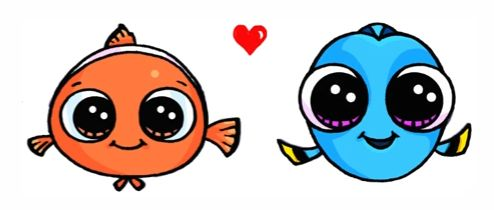

## Phân tích từng chỉ số R,F,M theo segment

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
avg_recency = rfm.groupby('Segment')['recency'].mean().reset_index()
avg_recency

,Segment,recency
0,About To Sleep,135.204545
1,At Risk,259.041667
2,Cannot Lose Them,496.527778
3,Champions,28.521127
4,Hibernating customers,190.044444
5,Lost customers,557.963855
6,Loyal,60.725806
7,Need Attention,50.138889
8,New Customers,41.475410
9,Potential Loyalist,45.185841


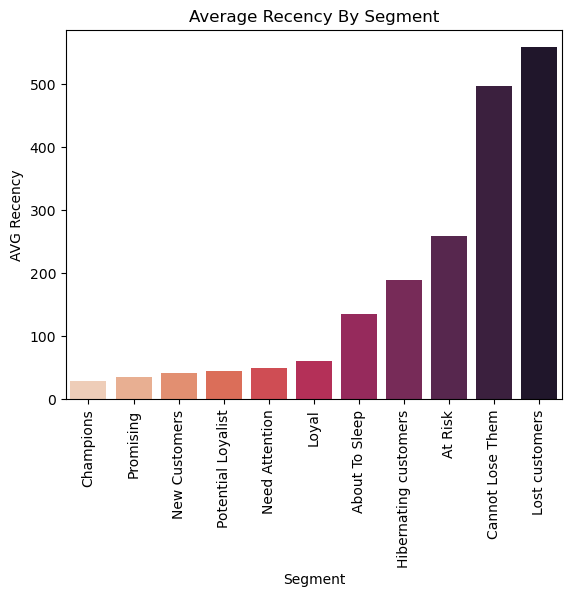

In [8]:
## RECENCY CHART
recency_chart = sns.barplot(x='Segment',y ='recency',data=avg_recency.sort_values('recency', ascending =True),errorbar=None, palette='rocket_r')
plt.xticks(rotation = 90)
recency_chart.set_title('Average Recency By Segment')
recency_chart.set(xlabel= 'Segment', ylabel= 'AVG Recency')
plt.show()

### Nhận xét:
+ Các segmentations mua hàng gần đây nhất: Champions (28,5 days), Promising (35 days), New customer (41.5 days)
+ Các segmentations đã lâu không mua hàng: Cannot Lose Them (496,5 days), Lost customers (558 days)

In [9]:
## AVG Frequency By Segment
avg_frequency = rfm.groupby('Segment')['frequency'].mean().reset_index()
avg_frequency.sort_values('frequency',ascending =False )

,Segment,frequency
3,Champions,9.830986
6,Loyal,8.161290
1,At Risk,7.260417
9,Potential Loyalist,7.079646
7,Need Attention,6.527778
0,About To Sleep,4.750000
4,Hibernating customers,4.733333
2,Cannot Lose Them,4.694444
10,Promising,4.507937
8,New Customers,3.393443


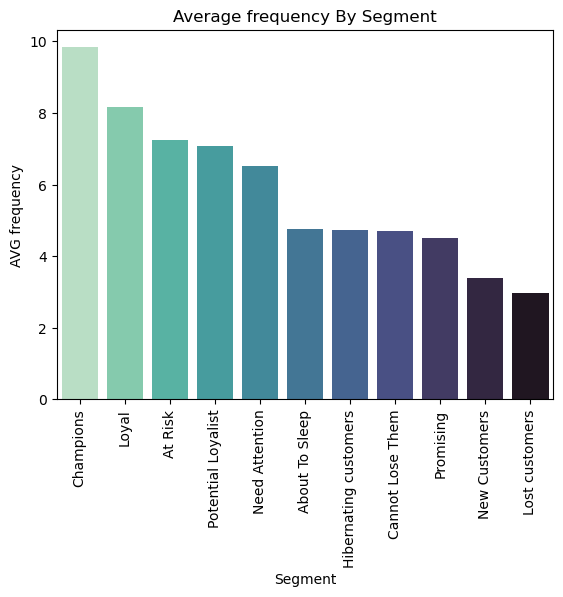

In [10]:
frequency_chart = sns.barplot(x='Segment',y ='frequency',data=avg_frequency.sort_values('frequency', ascending =False),errorbar=None,palette='mako_r')
plt.xticks(rotation = 90)
frequency_chart.set_title('Average frequency By Segment')
frequency_chart.set(xlabel= 'Segment', ylabel= 'AVG frequency')
plt.show()

### Nhận xét:
Phân khúc có tần suất mua hàng cao nhất (Champions) gấp 3.3 lần so với phân khúc có tần suất mua hàng thấp nhất (Lost Customer)
+ Những phân khúc có tần suất mua hàng cao: Champions (10 lần), Loyal (8 lần), At Risk & Potential Loyalist (7 lần), Need Attention (6.5 lần)
+ Lưu ý đặt biết tới phân khúc khách hàng cần có chính sách chăm sóc New Customers (3.4 lần)

In [11]:
## AVG monetary By Segment
avg_monetary = rfm.groupby('Segment')['monetary'].mean().reset_index()
avg_monetary.sort_values('monetary',ascending= False)

,Segment,monetary
3,Champions,5381.642068
6,Loyal,4365.809926
2,Cannot Lose Them,4173.053928
1,At Risk,4020.800897
7,Need Attention,3602.949892
10,Promising,3568.315802
9,Potential Loyalist,1689.778144
4,Hibernating customers,1221.780567
0,About To Sleep,1075.229936
8,New Customers,672.084279


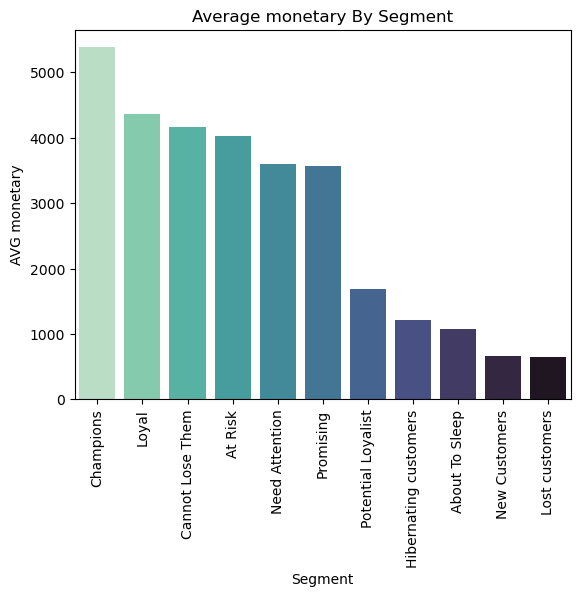

In [12]:
monetary_chart = sns.barplot(x='Segment',y ='monetary',data=avg_monetary.sort_values('monetary', ascending =False),errorbar=None,palette='mako_r')
plt.xticks(rotation = 90)
monetary_chart.set_title('Average monetary By Segment')
monetary_chart.set(xlabel= 'Segment', ylabel= 'AVG monetary')
plt.show()

### Nhận xét:
- Phân khúc Champions chiếm doanh thu trung bình cao nhất (5382 đvtt)
- Một đặc thù là phân khúc At Risk lại đặt mức doanh thu khá cao với hơn 4000 đvtt, trong khi phân khúc khách Potential Loyalist lại có mức doanh thu tương đối khiêm tốn xấp xỉ 1690 đvtt.

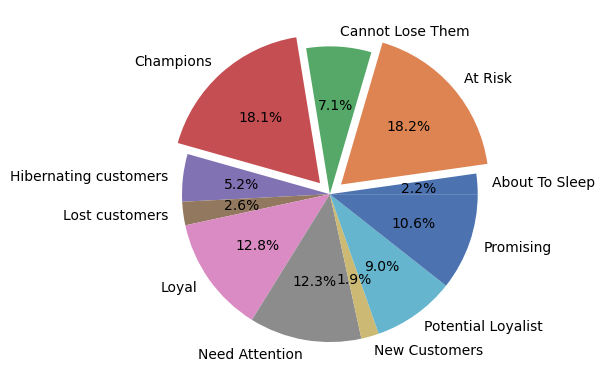

In [13]:
## Pie chart of total sales by segment
total_monetary = rfm.groupby('Segment')['monetary'].sum().reset_index()
palette_color = sns.color_palette('deep')
plt.pie(total_monetary['monetary'], labels=total_monetary['Segment'], colors=palette_color,explode=[0,0.1,0,0.1,0,0,0,0,0,0,0], autopct='%.1f%%')
plt.show()

### Nhận xét:
- Doanh thu chủ yếu đến từ các phân khúc: At Risk(18.2%), Champions(18.1%), Loyal(12.8%), Need Attention(12.3%), Promising(10.6%)
- Cần quan tâm đến phân khúc At Risk, nhóm này đem lại doanh thu cao 

##  Phân tích mối quan hệ giữa Recency, Frequency, Monetary 

### Mối quan hệ giữa Recency và Monetary

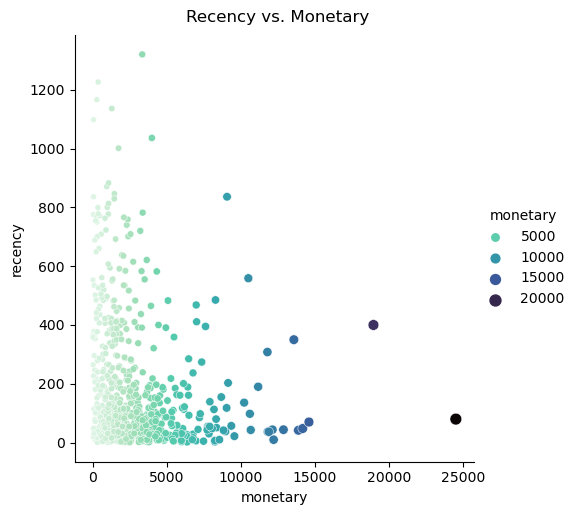

In [28]:
mon_cen = sns.relplot(x='monetary',y='recency',data= rfm, size='monetary',hue='monetary', kind='scatter',palette='mako_r')
mon_cen.fig.suptitle('Recency vs. Monetary', y=1.02)
plt.show()

### Nhận xét:
- Những khách hàng đã mua hàng gần đây tạo ra nhiều doanh thu hơn so với những khách hàng đã mua hàng trong quá khứ. 

- Những khách hàng đã mua hàng trong quá khứ gần có nhiều khả năng quay lại hơn so với những khách đã mua hàng cách đây lâu vì hầu hết những khách hàng đó sẽ là Lost customers

Như vậy, doanh thu cao hơn sẽ được liên kết với các KH mua hàng gần nhất: các phân khúc Champions, Promising, New Customers, Potential Loyalist, Need Attention, Loyal ( Dựa trên Recency Chart)

### Mối quan hệ giữa Frequency và Monetary

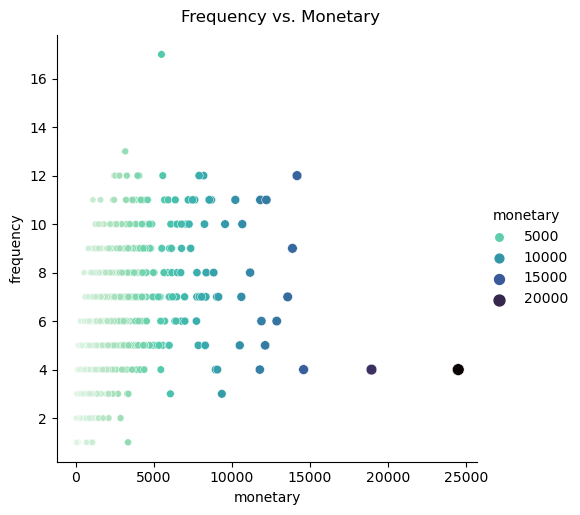

In [29]:
mon_fre = sns.relplot(x='monetary',y='frequency',data= rfm,size='monetary',hue='monetary', kind='scatter',palette='mako_r')
mon_fre.fig.suptitle('Frequency vs. Monetary', y=1.02)
plt.show()

### Nhận xét:
- Khi tần suất mua hàng tăng, doanh thu cũng tăng lên. 
- Những khách hàng ghé thăm thường xuyên hơn là những khách hàng trong phân khúc Champions, Loyal, At Risk, Potential Loyalist, Need Attention. Họ đẩy doanh thu cao hơn (Dựa trên Frequency Chart)

### Mối quan hệ giữa Frequency và Recency

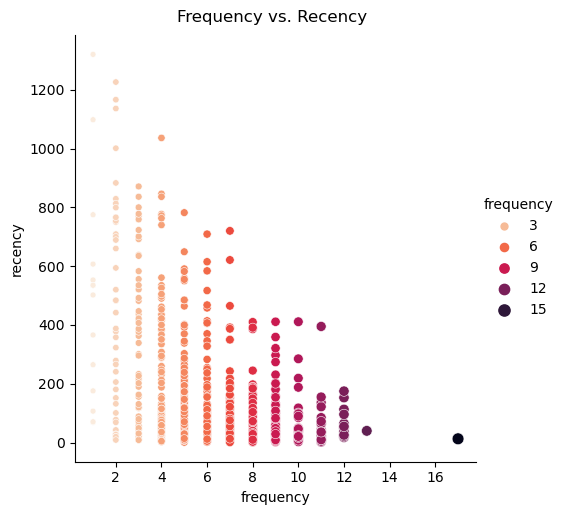

In [24]:
re_fre = sns.relplot(x='frequency',y='recency',data= rfm, kind='scatter', size='frequency',hue='frequency',palette='rocket_r')
re_fre.fig.suptitle('Frequency vs. Recency', y=1.02)
plt.show()

### Nhận xét: 
- Khách hàng ghé thăm gần đây có tần suất mua hàng nhiều hơn 
- KH ghé thăm gần nhất: các phân khúc Champions, Promising, New Customers( Dựa trên Recency Chart)

### Phân tích số lượng khách hàng theo Segment

In [53]:
cus = rfm.groupby('Segment')['Customer ID'].count().reset_index()
total = cus['Customer ID'].sum()
cus['%'] = 100 * cus['Customer ID'] / total 
cus.rename(columns={'Customer ID':'Quantity'},inplace=True)
cus.sort_values('%', ascending=False)

,Segment,Quantity,%
9,Potential Loyalist,113,14.285714
1,At Risk,96,12.136536
4,Hibernating customers,90,11.378003
5,Lost customers,83,10.493047
7,Need Attention,72,9.102402
3,Champions,71,8.975980
10,Promising,63,7.964602
6,Loyal,62,7.838180
8,New Customers,61,7.711757
0,About To Sleep,44,5.562579


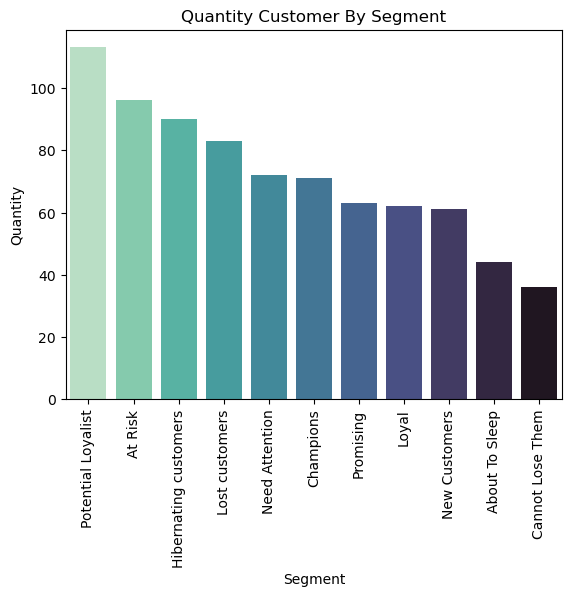

In [51]:
cus_chart = sns.barplot(x='Segment',y='Quantity',data= cus.sort_values('Quantity', ascending=False), palette= 'mako_r')
plt.xticks(rotation = 90)
cus_chart.set_title('Quantity Customer By Segment')
plt.show()

### Nhận xét:
- Potential Loyalist chiếm số lượng khách hàng nhiều nhất (14.28%)
- Những phân khúc có số lượng khách cao nhưng lại thuộc phân khúc báo động như At Risk (12.1%), Hibernating customers( 11.4%). Trong đó, At Risk (18.2% chiếm Doanh số)
=> Cần chú ý và quan tâm đến phân khúc At Risk này

# Recomendation:
Từ những kết quả phân tích cơ bản bên trên, chúng ta có thể đưa ra một số kết luận sau:

- Ưu tiên thiết kế và triển khai các chương trình dành cho hai phân khúc khách hàng Champions, Loyal với kỳ vọng mang lại lợi nhuận cao, ít rủi ro, tiếp cận hiệu quả. Hai nhóm này mua gần đây, tần suất mua hàng cao, chiếm % doanh thu lớn, và giá trị đơn hàng trung bình (AVG Monetary) cũng cao.

- Có chính sách hoặc xây dựng hệ thống sản phẩm hiệu quả, linh hoạt hơn hướng tới nhóm phân khúc khách hàng Potential Loyalist nhằm khai thác lượng lớn khách hàng được coi là khách hàng tiềm năng trở thành khách hàng thân thiết mang lại lợi nhuận lâu dài cho công ty. Vì nhóm này đang chiếm 14.28% tổng số lượng khách hàng, tần suất mua hàng cao.

- Đặc biệt chú ý đến phân khúc At Risk, cần có giải pháp hiệu quả cho phân khúc này vì At Risk chiếm TOP 1 doanh thu 18,2%, tần suất mua hàng khá lớn, giá trị đơn hàng cao, và đang chiếm số lượng khách hàng lớn (12.1%) -> Cần tìm hiểu nguyên nhân vì sao nhóm KH này không quay trở lại mua hàng trong nhiều ngày và thu hút họ quay trở lại bằng các giải pháp phù hợp.
- Tiếp đến cần quan tâm đến hai phân khúc Need Attention và Promising vì chiếm doanh thu cao lần lượt là 12.3%, 10.6%. Cần xây dựng chiến lược cho hai phân khúc này vì rất có tiềm năng trở thành khách hàng trung thành. Hơn nữa, phân khúc Need Attention có số lượng khách hàng lớn, tần suất mua hàng cao, doanh thu và giá trị đơn hàng cao. 


# Nên quan tâm chỉ số nào R,F,M?
Dựa vào những phân khúc đã nêu ở phần Recomendation:
- Champions, Loyal : 3 chỉ số R,F,M tương đối cao 
- Potential Loyalist: còn hạn chế ở chỉ số R và M
- At Risk: chỉ số R thấp, đã lâu ko mua hàng, nhưng F và M tương đối cao, cần tập trung chỉ số R
- Need Attention: chỉ số F và M cao, nhưng R thấp, cần tập trung chỉ số R

NÊN QUAN TÂM NHẤT VÀO CHỈ SỐ R